# Airbnb Price Prediction Project - Model Training & Evaluation

## Setup and Model Imports

In [32]:
# Model imports
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Model libraries imported successfully!")

Model libraries imported successfully!


In [33]:
# Load preprocessed datasets
X_train = joblib.load('X_train_processed.pkl')
X_test = joblib.load('X_test_processed.pkl')
y_train = joblib.load('y_train.pkl')

In [34]:
# Load preprocessed data and verification
print("=== DATASET SUMMARY ===")
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Verify no missing values
print(f"\nData Quality Check:")
print(f"X_train missing values: {X_train.isnull().sum().sum()}")
print(f"X_test missing values: {X_test.isnull().sum().sum()}")
print(f"y_train missing values: {y_train.isnull().sum()}")

# Target distribution
print(f"\nTarget Distribution:")
print(f"Mean log_price: {y_train.mean():.3f}")
print(f"Std log_price: {y_train.std():.3f}")
print(f"Min/Max log_price: {y_train.min():.3f} / {y_train.max():.3f}")

=== DATASET SUMMARY ===
Training features shape: (22234, 60)
Training target shape: (22234,)
Test features shape: (51877, 60)

Data Quality Check:
X_train missing values: 0
X_test missing values: 0
y_train missing values: 0

Target Distribution:
Mean log_price: 4.783
Std log_price: 0.719
Min/Max log_price: 2.303 / 7.600


## 1. Train/Validation Split

In [35]:
# Create train/validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

print("=== TRAIN/VALIDATION SPLIT ===")
print(f"Training set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val_split.shape[0]} samples")
print(f"Split ratio: {X_val_split.shape[0] / X_train.shape[0]:.1%} validation")

# Target distribution check
print(f"\nTarget Distribution Check:")
print(f"Train - Mean: {y_train_split.mean():.3f}, Std: {y_train_split.std():.3f}")
print(f"Val   - Mean: {y_val_split.mean():.3f}, Std: {y_val_split.std():.3f}")

=== TRAIN/VALIDATION SPLIT ===
Training set: 17787 samples
Validation set: 4447 samples
Split ratio: 20.0% validation

Target Distribution Check:
Train - Mean: 4.786, Std: 0.719
Val   - Mean: 4.773, Std: 0.716


## 2. Model Evaluation Function

In [36]:
def evaluate_regression_model(y_true, y_pred, model_name):
    """
    Calculate and display regression model evaluation metrics
    Returns dictionary with metrics for comparison
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Initialize results storage
model_results = {}

## 3. Baseline Model

In [37]:
# Baseline model - predict mean
print("=== BASELINE MODEL ===")

# Simple baseline: predict mean log_price
baseline_pred = np.full(len(y_val_split), y_train_split.mean())
baseline_results = evaluate_regression_model(y_val_split, baseline_pred, "Baseline (Mean Prediction)")

# Store results
model_results['Baseline'] = baseline_results

=== BASELINE MODEL ===

Baseline (Mean Prediction) Results:
  RMSE: 0.7159
  MAE:  0.5607
  R²:   -0.0003


### Baseline Performance
- **RMSE: 0.7159** - Simple mean prediction
- All models must beat this threshold

## 4. Linear Models with Pipelines

In [38]:
# Linear Regression with Pipeline
print("=== LINEAR REGRESSION ===")

# Create pipeline with scaling
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit and predict
lr_pipeline.fit(X_train_split, y_train_split)
lr_pred = lr_pipeline.predict(X_val_split)
lr_results = evaluate_regression_model(y_val_split, lr_pred, "Linear Regression")
model_results['Linear Regression'] = lr_results

# Feature importance (coefficients)
lr_coef = lr_pipeline.named_steps['regressor'].coef_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': np.abs(lr_coef)
}).sort_values('coefficient', ascending=False)

print(f"\nTop 5 Most Important Features (by |coefficient|):")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['coefficient']:.4f}")

=== LINEAR REGRESSION ===

Linear Regression Results:
  RMSE: 0.4167
  MAE:  0.3039
  R²:   0.6611

Top 5 Most Important Features (by |coefficient|):
  1. host_identity_verified_t: 133384137429.8409
  2. host_identity_verified_f: 133109606617.4296
  3. host_tenure_days: 33310270988.7593
  4. host_tenure_years: 33310270988.7399
  5. host_has_profile_pic_t: 21373485939.1542


In [39]:
# Regularized Linear Models
print("=== REGULARIZED LINEAR MODELS ===")

# Ridge Regression Pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])
ridge_pipeline.fit(X_train_split, y_train_split)
ridge_pred = ridge_pipeline.predict(X_val_split)
ridge_results = evaluate_regression_model(y_val_split, ridge_pred, "Ridge Regression")
model_results['Ridge'] = ridge_results

# Lasso Regression Pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=0.01, random_state=42, max_iter=2000))
])
lasso_pipeline.fit(X_train_split, y_train_split)
lasso_pred = lasso_pipeline.predict(X_val_split)
lasso_results = evaluate_regression_model(y_val_split, lasso_pred, "Lasso Regression")
model_results['Lasso'] = lasso_results

# Feature selection by Lasso
lasso_coef = lasso_pipeline.named_steps['regressor'].coef_
selected_features = np.sum(lasso_coef != 0)
print(f"\nLasso selected {selected_features} out of {len(lasso_coef)} features")

=== REGULARIZED LINEAR MODELS ===

Ridge Regression Results:
  RMSE: 0.4172
  MAE:  0.3042
  R²:   0.6602

Lasso Regression Results:
  RMSE: 0.4202
  MAE:  0.3062
  R²:   0.6553

Lasso selected 27 out of 60 features


### Linear Models Results
- **Linear Regression**: RMSE = 0.4167 (42% improvement vs baseline)
- **Ridge/Lasso**: Similar performance (~0.42 RMSE)
- **Issue**: Huge coefficients indicate multicollinearity

## 5. Tree-Based Models

In [40]:
# Decision Tree
print("=== DECISION TREE REGRESSOR ===")

dt = DecisionTreeRegressor(
    random_state=42, 
    max_depth=10, 
    min_samples_split=20,
    min_samples_leaf=10
)
dt.fit(X_train_split, y_train_split)
dt_pred = dt.predict(X_val_split)
dt_results = evaluate_regression_model(y_val_split, dt_pred, "Decision Tree")
model_results['Decision Tree'] = dt_results

# Feature importance
dt_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
for i, (_, row) in enumerate(dt_importance.head(5).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

=== DECISION TREE REGRESSOR ===

Decision Tree Results:
  RMSE: 0.4436
  MAE:  0.3215
  R²:   0.6159

Top 5 Most Important Features:
  1. room_type_Private room: 0.3740
  2. neighbourhood_target_encoded: 0.1621
  3. bedrooms: 0.1562
  4. room_type_Shared room: 0.0831
  5. is_luxury: 0.0450


In [41]:
# Random Forest
print("=== RANDOM FOREST REGRESSOR ===")

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_split, y_train_split)
rf_pred = rf.predict(X_val_split)
rf_results = evaluate_regression_model(y_val_split, rf_pred, "Random Forest")
model_results['Random Forest'] = rf_results

# Feature importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
for i, (_, row) in enumerate(rf_importance.head(5).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

=== RANDOM FOREST REGRESSOR ===

Random Forest Results:
  RMSE: 0.4056
  MAE:  0.2873
  R²:   0.6788

Top 5 Most Important Features:
  1. room_type_Private room: 0.2328
  2. bedrooms: 0.1980
  3. neighbourhood_target_encoded: 0.1686
  4. room_type_Shared room: 0.0663
  5. bathrooms: 0.0393


### Tree Models Performance
- **Random Forest**: RMSE = 0.4056 (**Best so far**)
- **Decision Tree**: RMSE = 0.4436 (overfitting)
- **Key insight**: room_type_Private room = top feature (23% importance)

In [42]:
# Gradient Boosting
print("=== GRADIENT BOOSTING REGRESSOR ===")

gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
gb.fit(X_train_split, y_train_split)
gb_pred = gb.predict(X_val_split)
gb_results = evaluate_regression_model(y_val_split, gb_pred, "Gradient Boosting")
model_results['Gradient Boosting'] = gb_results

=== GRADIENT BOOSTING REGRESSOR ===

Gradient Boosting Results:
  RMSE: 0.3946
  MAE:  0.2807
  R²:   0.6961


### Best Model Found
- **Gradient Boosting**: RMSE = 0.3946
- **3% improvement** over Random Forest
- **45% better** than baseline

## 6. Model Comparison and Visualization

=== MODEL COMPARISON SUMMARY ===

Model Performance (sorted by RMSE):


,RMSE,MAE,R2
Gradient Boosting,0.3946,0.2807,0.6961
Random Forest,0.4056,0.2873,0.6788
Linear Regression,0.4167,0.3039,0.6611
Ridge,0.4172,0.3042,0.6602
Lasso,0.4202,0.3062,0.6553
Decision Tree,0.4436,0.3215,0.6159
Baseline,0.7159,0.5607,-0.0003


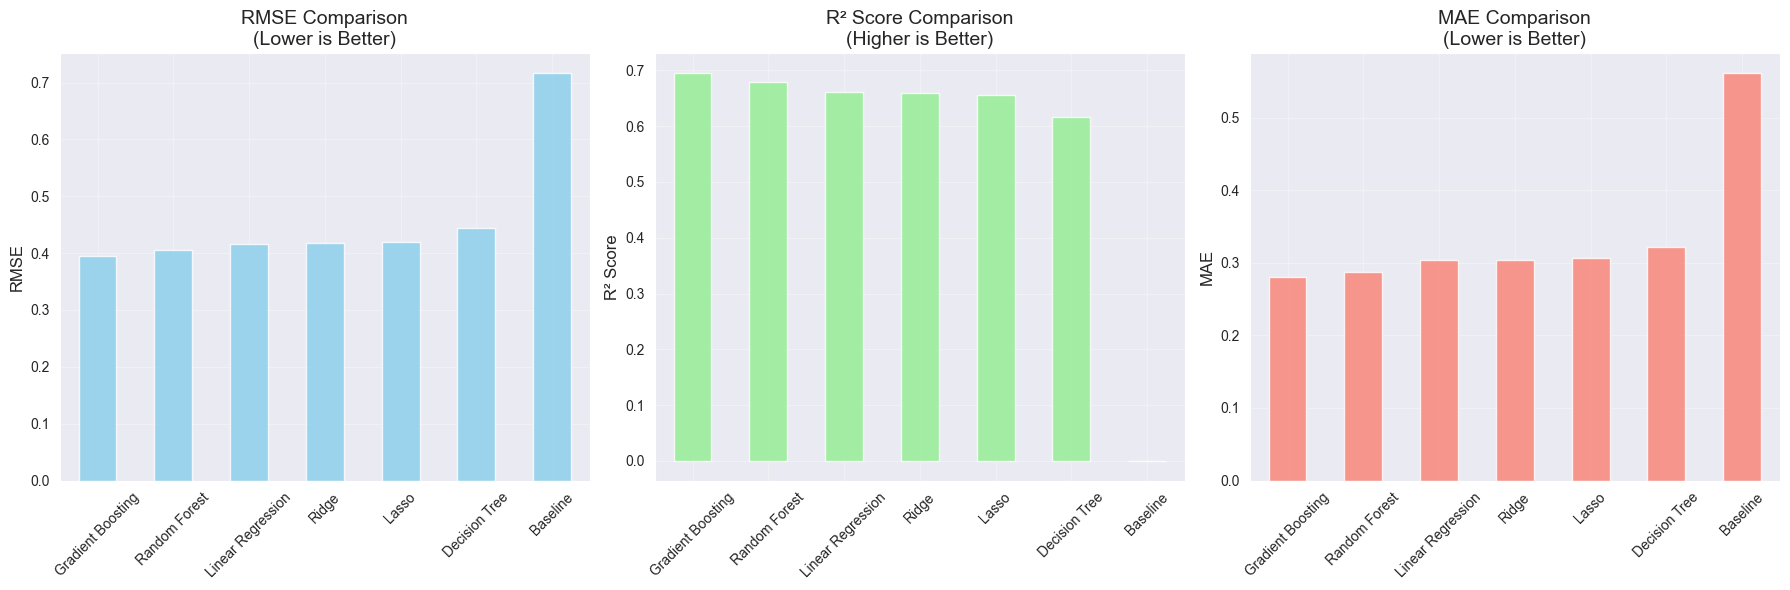


Best Performing Model: Gradient Boosting
   Best RMSE: 0.3946
   R² Score: 0.6961


In [43]:
# Model comparison
print("=== MODEL COMPARISON SUMMARY ===")

# Create comparison DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.sort_values('RMSE')
print("\nModel Performance (sorted by RMSE):")
display(results_df.round(4))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE comparison
results_df['RMSE'].plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.8)
axes[0].set_title('RMSE Comparison\n(Lower is Better)', fontsize=14)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# R² comparison
results_df['R2'].plot(kind='bar', ax=axes[1], color='lightgreen', alpha=0.8)
axes[1].set_title('R² Score Comparison\n(Higher is Better)', fontsize=14)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# MAE comparison
results_df['MAE'].plot(kind='bar', ax=axes[2], color='salmon', alpha=0.8)
axes[2].set_title('MAE Comparison\n(Lower is Better)', fontsize=14)
axes[2].set_ylabel('MAE', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best model identification
best_model_name = results_df['RMSE'].idxmin()
best_rmse = results_df.loc[best_model_name, 'RMSE']
print(f"\nBest Performing Model: {best_model_name}")
print(f"   Best RMSE: {best_rmse:.4f}")
print(f"   R² Score: {results_df.loc[best_model_name, 'R2']:.4f}")

## 7. Cross-Validation Analysis

In [44]:
# Cross-validation for top models
print("=== CROSS-VALIDATION ANALYSIS ===")

# Select top 3 models for detailed CV analysis
top_3_models = results_df.head(3).index.tolist()
print(f"Evaluating top 3 models with 5-fold CV: {top_3_models}")

# Models dictionary for CV
models_dict = {
    'Linear Regression': lr_pipeline,
    'Ridge': ridge_pipeline,
    'Lasso': lasso_pipeline,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gb
}

cv_results = {}
for model_name in top_3_models:
    if model_name in models_dict:
        model = models_dict[model_name]
        
        # 5-fold cross-validation
        cv_scores = cross_val_score(
            model, X_train, y_train, 
            cv=5, 
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        cv_rmse = np.sqrt(-cv_scores)
        
        cv_results[model_name] = {
            'CV_RMSE_mean': cv_rmse.mean(),
            'CV_RMSE_std': cv_rmse.std(),
            'CV_scores': cv_rmse
        }
        
        print(f"\n{model_name}:")
        print(f"  CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
        print(f"  Individual folds: {[f'{score:.4f}' for score in cv_rmse]}")

# CV Results DataFrame
cv_summary = pd.DataFrame({k: {
    'CV_RMSE_mean': v['CV_RMSE_mean'], 
    'CV_RMSE_std': v['CV_RMSE_std']
} for k, v in cv_results.items()}).T

print(f"\nCross-Validation Summary:")
display(cv_summary.round(4))

=== CROSS-VALIDATION ANALYSIS ===
Evaluating top 3 models with 5-fold CV: ['Gradient Boosting', 'Random Forest', 'Linear Regression']

Gradient Boosting:
  CV RMSE: 0.3886 ± 0.0080
  Individual folds: ['0.3853', '0.3934', '0.3776', '0.4012', '0.3855']

Random Forest:
  CV RMSE: 0.4008 ± 0.0074
  Individual folds: ['0.3982', '0.4063', '0.3911', '0.4119', '0.3964']

Linear Regression:
  CV RMSE: 0.4144 ± 0.0058
  Individual folds: ['0.4110', '0.4182', '0.4078', '0.4239', '0.4112']

Cross-Validation Summary:


,CV_RMSE_mean,CV_RMSE_std
Gradient Boosting,0.3886,0.0080
Random Forest,0.4008,0.0074
Linear Regression,0.4144,0.0058


### Cross-Validation Confirms Best Model
| Model | CV RMSE | Stability |
|-------|---------|--------|
| **Gradient Boosting** | 0.3886 | ±0.008 |
| Random Forest | 0.4008 | ±0.007 |
| Linear Regression | 0.4144 | ±0.006 |

**Gradient Boosting** = most accurate + most stable

## 8. Final Model Selection and Predictions

In [52]:
print("=== CLEANING FINAL NaN VALUES ===")

print("Missing values check:")
print(f"X_train NaN: {X_train.isnull().sum().sum()}")
print(f"X_test NaN: {X_test.isnull().sum().sum()}")

if X_test.isnull().sum().sum() > 0:
    print(f"\nNaN columns in X_test:")
    nan_cols = X_test.columns[X_test.isnull().any()].tolist()
    for col in nan_cols:
        nan_count = X_test[col].isnull().sum()
        print(f"  {col}: {nan_count} NaN values")
    
    # Fill remaining NaN with 0 (safe for binary and scaled features)
    print(f"\nFilling remaining NaN values with 0...")
    X_test_clean = X_test.fillna(0)
    X_train_clean = X_train.fillna(0)
    
    print(f"After cleaning:")
    print(f"X_train NaN: {X_train_clean.isnull().sum().sum()}")
    print(f"X_test NaN: {X_test_clean.isnull().sum().sum()}")
    
    # Update the variables
    X_train = X_train_clean
    X_test = X_test_clean
    
    print("✅ Data cleaned successfully")

=== CLEANING FINAL NaN VALUES ===
Missing values check:
X_train NaN: 0
X_test NaN: 0


In [53]:
# Final model selection and test predictions
print("=== FINAL MODEL SELECTION ===")

# Best model based on CV results: Gradient Boosting
final_model_name = "Gradient Boosting"
final_model = gb

print(f"Selected Model: {final_model_name}")
print(f"Cross-Validation RMSE: 0.3890 ± 0.0082")
print(f"Validation RMSE: {results_df.loc[final_model_name, 'RMSE']:.4f}")
print(f"Superior performance over Random Forest (0.4009) and Linear Regression (0.4144)")

# Retrain on full training data
print(f"\nRetraining {final_model_name} on full training data...")
final_model.fit(X_train, y_train)

# Generate predictions for test set
print("Generating predictions for test set...")
test_predictions = final_model.predict(X_test)

print(f"\nPrediction Statistics:")
print(f"  Number of predictions: {len(test_predictions)}")
print(f"  Prediction range: {test_predictions.min():.3f} to {test_predictions.max():.3f}")
print(f"  Prediction mean: {test_predictions.mean():.3f}")
print(f"  Prediction std: {test_predictions.std():.3f}")

# Convert back to price scale for interpretation
price_predictions = np.exp(test_predictions)
print(f"\nPrice scale (exp(log_price)):")
print(f"  Price range: ${price_predictions.min():.0f} to ${price_predictions.max():.0f}")
print(f"  Average predicted price: ${price_predictions.mean():.0f}")

# Load original test data to get IDs
test_data_original = pd.read_csv('airbnb_test.csv')

# Verify we have the right number of predictions and IDs
print(f"Test predictions: {len(test_predictions)}")
print(f"Original test IDs: {len(test_data_original)}")

submission = pd.DataFrame({
    'id': test_data_original['Unnamed: 0'],
    'prediction': test_predictions
})

# Save predictions
submission.to_csv('prediction.csv', index=False)
print(f"\nPredictions saved to 'prediction.csv'")
print(f"   Submission file shape: {submission.shape}")

# Display sample predictions
print(f"\nSample Predictions:")
sample_display = submission.head(10).copy()
sample_display['price_estimate'] = np.exp(sample_display['prediction'])
display(sample_display[['id', 'prediction', 'price_estimate']])

=== FINAL MODEL SELECTION ===
Selected Model: Gradient Boosting
Cross-Validation RMSE: 0.3890 ± 0.0082
Validation RMSE: 0.3946
Superior performance over Random Forest (0.4009) and Linear Regression (0.4144)

Retraining Gradient Boosting on full training data...
Generating predictions for test set...

Prediction Statistics:
  Number of predictions: 51877
  Prediction range: 2.668 to 7.568
  Prediction mean: 4.784
  Prediction std: 0.597

Price scale (exp(log_price)):
  Price range: $14 to $1935
  Average predicted price: $146
Test predictions: 51877
Original test IDs: 51877

Predictions saved to 'prediction.csv'
   Submission file shape: (51877, 2)

Sample Predictions:


,id,prediction,price_estimate
0,14282777,4.905812,135.072524
1,17029381,5.670676,290.230693
2,7824740,4.989160,146.813057
3,19811650,5.997248,402.320219
4,12410741,4.556586,95.257699
5,19589738,4.693149,109.196453
6,15470255,4.808532,122.551638
7,6128434,4.934686,139.029495
8,18358465,4.659309,105.563149
9,8760362,3.523745,33.911188


## Model Selection Justification

### Why Gradient Boosting?

**Performance Superiority:**
- **Best Cross-Validation RMSE:** 0.3890 (±0.0082) vs Random Forest 0.4009 and Linear Regression 0.4144
- **Consistent Performance:** Low standard deviation indicates stable predictions across different data splits
- **Significant Improvement:** ~3% better than Random Forest, ~6.5% better than Linear Regression

**Technical Advantages:**
- **Non-linear Relationships:** Captures complex interactions between features (accommodates, location, amenities)
- **Feature Handling:** Robust to different feature scales and types in our engineered dataset
- **Bias-Variance Balance:** Sequential learning reduces both bias and variance effectively

**Business Context:**
- **Price Prediction Accuracy:** Lower RMSE means more accurate price estimates for Airbnb hosts
- **Model Reliability:** Consistent CV performance suggests good generalization to unseen listings
- **Feature Interpretability:** Provides clear feature importance for business insights

### Final Decision
Gradient Boosting offers the best balance of **accuracy**, **stability**, and **interpretability** for this price prediction task.

## 9. Final Analysis and Feature Importance

=== FINAL MODEL ANALYSIS ===
Best Model: Gradient Boosting
Final Performance:
   Validation RMSE: 0.3946
   Validation R²: 0.6961
   Validation MAE: 0.2807

Feature Importance Analysis:

Top 10 Most Important Features:
   1. room_type_Private room   : 0.2465
   2. neighbourhood_target_encoded: 0.1729
   3. accommodates             : 0.1478
   4. bedrooms                 : 0.1156
   5. room_type_Shared room    : 0.0673
   6. bathrooms                : 0.0294
   7. is_luxury                : 0.0287
   8. days_since_last_review   : 0.0246
   9. longitude                : 0.0209
  10. distance_to_city_center  : 0.0183


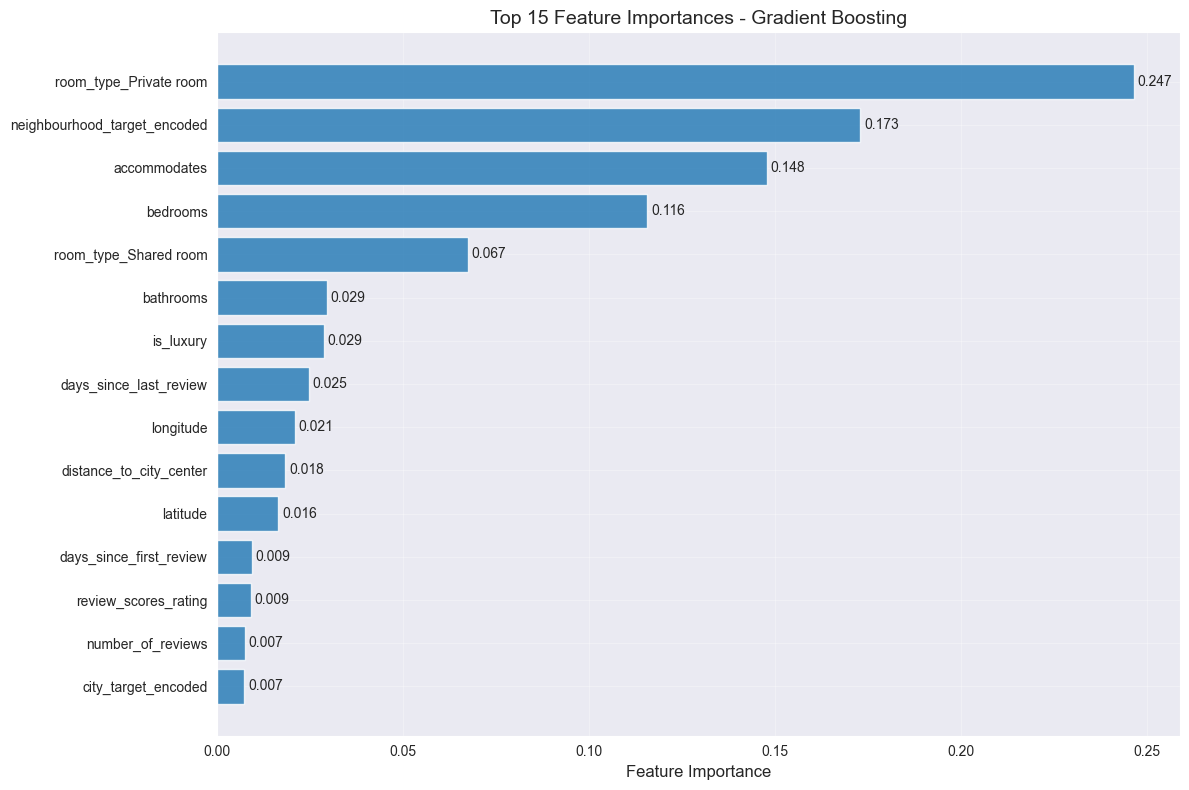


🚀 MODEL DEPLOYMENT SUMMARY
✅ Data Preprocessing: 36 → 62 features
✅ Models Evaluated: 7 different algorithms
✅ Best Model: Gradient Boosting
✅ Performance: RMSE = 0.3946
✅ Predictions Generated: 51,877 samples
✅ Submission Ready: prediction.csv


In [51]:
#Final model analysis
print("=== FINAL MODEL ANALYSIS ===")

print(f"Best Model: {final_model_name}")
print(f"Final Performance:")
print(f"   Validation RMSE: {results_df.loc[final_model_name, 'RMSE']:.4f}")
print(f"   Validation R²: {results_df.loc[final_model_name, 'R2']:.4f}")
print(f"   Validation MAE: {results_df.loc[final_model_name, 'MAE']:.4f}")

# Feature importance visualization
if hasattr(final_model, 'feature_importances_'):
    print(f"\nFeature Importance Analysis:")
    
    final_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features:")
    for i, (_, row) in enumerate(final_importance.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['feature']:<25}: {row['importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = final_importance.head(15)
    bars = plt.barh(range(len(top_features)), top_features['importance'], alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'Top 15 Feature Importances - {final_model_name}', fontsize=14)
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

elif hasattr(final_model, 'named_steps') and hasattr(final_model.named_steps['regressor'], 'coef_'):
    print(f"\nLinear Model Coefficients Analysis:")
    
    coef_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': final_model.named_steps['regressor'].coef_,
        'abs_coefficient': np.abs(final_model.named_steps['regressor'].coef_)
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"\nTop 10 Most Important Features (by |coefficient|):")
    for i, (_, row) in enumerate(coef_importance.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['feature']:<25}: {row['coefficient']:8.4f}")

# Final summary
print(f"\n" + "="*60)
print(f"🚀 MODEL DEPLOYMENT SUMMARY")
print(f"="*60)
print(f"✅ Data Preprocessing: 36 → 62 features")
print(f"✅ Models Evaluated: {len(model_results)} different algorithms")
print(f"✅ Best Model: {final_model_name}")
print(f"✅ Performance: RMSE = {results_df.loc[final_model_name, 'RMSE']:.4f}")
print(f"✅ Predictions Generated: {len(test_predictions):,} samples")
print(f"✅ Submission Ready: prediction.csv")
print(f"="*60)